### Imports

In [1]:
import os
import h5py as h5
import json

import numpy as np
from scipy.optimize import curve_fit
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.patches as patches
    
# local imports (found in this repo)
from utils import *
from deconv import *
from releaser import Releaser, mini_releaser
from animator import SacSacAnimator, ball_sticks
from scalebars import add_scalebar

### Activate interactive plotting
By default, inline plots are static. Here we specify one of two options (comment out the undesired command) that will open plots with GUI controls for us.
- **qt ->** figures opened in windows outside the notebook
- **notebook ->** figures within notebook underneath generating cell.

In [2]:
# %matplotlib qt
%matplotlib notebook
plt.rcParams.update({"figure.max_open_warning": 0})

In [3]:
base_path = "/mnt/Data/NEURONoutput/" + "sac_sac/"
# model_path = base_path + "model_runs/elife_resub/"
# load_name = "sust_trans_range_20tr"
model_path = base_path + "model_runs/elife_resub_range_redo/"
# load_name = "sust_trans_range_redo"
# load_name = "sust_trans_range_redo_x1p5"
load_name = "sust_trans_range_redo_x2p5"

In [14]:
vel_idx = 2
with h5.File(os.path.join(model_path, load_name + ".h5"), "r") as f:
    data = {
        int(n_bps): {
            sac: {
                metric : f[n_bps]["no_gaba"]["data"]["term"][sac][metric][:, vel_idx]
                for metric in f[n_bps]["no_gaba"]["data"]["term"][sac].keys()
            }
            for sac in f[n_bps]["no_gaba"]["data"]["term"].keys()
        }
        for n_bps in f.keys()
    }
    model_params = json.loads(f["0"]["no_gaba"]["model_params"][()])
    exp_params = json.loads(f["0"]["no_gaba"]["exp_params"][()])
    
dt = exp_params["dt"]
rec_xaxis = np.arange(0, exp_params["tstop"] + dt, dt)
velocity = exp_params["velocities"][vel_idx]
rec_shape = data[0]["a"]["cai"].shape
print("dt = %.2f ms" % dt)
print("selected velocity = %.3f mm/s" % velocity)
print("recording shape =", rec_shape)

dt = 1.00 ms
selected velocity = 0.150 mm/s
recording shape = (20, 6001)


### PN DSi measurements
Here the bar is simply moving in the same direction, over SAC A then SAC B, but we can use the signals in the opposing SACs to calculate a preferred minus null direction selective index.

- **peak:** Using the deflection from the minimum voltage
- **thresh_area:** Area under the voltage above a specified threshold
- **iCa**: Area of calcium current (polarity flipped to positive)
- **gaba:** Area of GABA conductance *applied* the *opposing* SAC  

In [15]:
thresh = -40
dsis = {
    n_bps: { 
        "peak": pn_dsi(
            peak_vm_deflection(sacs["a"]["v"]),
            peak_vm_deflection(sacs["b"]["v"])
        ),
        "thresh_area": pn_dsi(
            thresholded_area(sacs["a"]["v"], thresh),
            thresholded_area(sacs["b"]["v"], thresh)
        ),
        "iCa": pn_dsi(
            np.sum(sacs["a"]["ica"] * -1, axis=-1),
            np.sum(sacs["b"]["ica"] * -1, axis=-1)
        ),
        "peak_[Ca]": pn_dsi(
            np.max(sacs["a"]["cai"], axis=-1),
            np.max(sacs["b"]["cai"], axis=-1)
        ),
    } 
    for n_bps, sacs in data.items()
}

In [16]:
print("dsi metric shape =", dsis[0]["peak_[Ca]"].shape)

dsi metric shape = (20,)


<IPython.core.display.Javascript object>


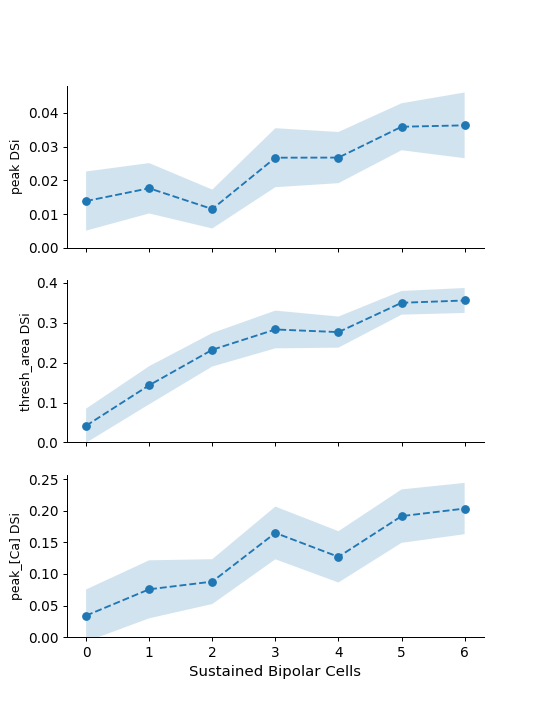

In [17]:
show_metrics = ["peak", "thresh_area", "peak_[Ca]"]
dsi_fig, dsi_ax = plt.subplots(len(show_metrics), sharex=True, figsize=(6, 8))
for i, (a, m) in enumerate(zip(dsi_ax, show_metrics)):
    n_sust = np.array(list(dsis.keys()))
    mean = np.array([np.mean(ds[m]) for ds in dsis.values()])
    std = np.array([np.std(ds[m]) for ds in dsis.values()])
    ste = std / np.sqrt(len(mean))
    a.fill_between(n_sust, mean + ste, mean - ste, alpha=0.2)
    a.plot(n_sust, mean, linestyle="--", marker="o")

for a, metric in zip(dsi_ax, show_metrics):
    a.set_ylabel("%s DSi" % metric)
    a.set_ylim(0)
    clean_axes(a)

dsi_ax[-1].set_xlabel("Sustained Bipolar Cells", fontsize=12)
dsi_fig.show()

<IPython.core.display.Javascript object>


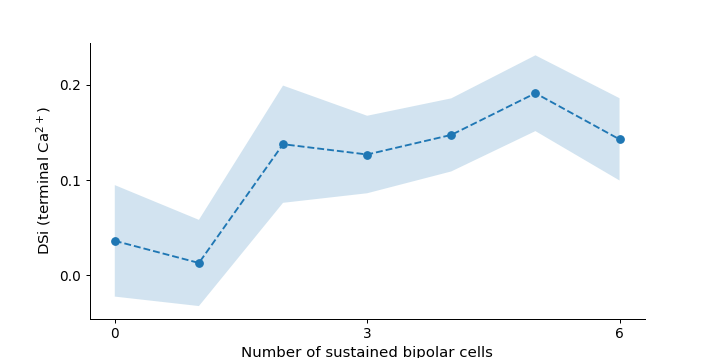

In [13]:
# ca_dsi_fig, ca_dsi_ax = plt.subplots(1)
ca_dsi_fig, ca_dsi_ax = plt.subplots(1, figsize=(8, 4))
n_sust = np.array(list(dsis.keys()))
mean = np.array([np.mean(ds["peak_[Ca]"]) for ds in dsis.values()])
std = np.array([np.std(ds["peak_[Ca]"]) for ds in dsis.values()])
ste = std / np.sqrt(len(mean))
ca_dsi_ax.fill_between(n_sust, mean + ste, mean - ste, alpha=0.2)
ca_dsi_ax.plot(n_sust, mean, linestyle="--", marker="o")

ca_dsi_ax.set_ylabel("DSi (terminal Ca$^{2+}$)", fontsize=12)
# ca_dsi_ax.set_yticks([0., 0.2, 0.4])
ca_dsi_ax.set_yticks([0., 0.1, 0.2])
ca_dsi_ax.set_xlabel("Number of sustained bipolar cells", fontsize=12)
ca_dsi_ax.set_xticks([0, 3, 6])
clean_axes(ca_dsi_ax)

ca_dsi_fig.show()
name = "sust_trans_range_%ium" % (velocity * 1000)
for ext in [".svg", ".png"]:
    ca_dsi_fig.savefig(os.path.join(model_path, name + ext), bbox_inches="tight")